# Groundwater system behavior simulation with convolution

IHE, transient groundwater

Olsthoorn, 2019-01-05

A solution, which shows the deline of the head in a strip due to bleeding to the fixed heads at both ends.

$$ s(x, t) = A \frac 4 \pi \sum _{j=1} ^\infty \left\{
\frac {(-1)^{j-1}} {2 j - 1}
\cos \left[(2 j -1) \frac \pi 2 \frac x b \right]
\exp \left[ -(2 j - 1)^2  \left( \frac \pi 2 \right)^2 \frac {kD} {b^2 S} t \right]
\right\} $$

The solution starts at an initial head equal to $A$ and then decays to a uniform head equal to 0. The head at $s(\pm b, t) =  0$.

To make sure that both reflex decay of an initial head of $a$ above the fixed heads at $x \pm L/2 = b$, we have to subtract the sudden head solutions from the initial head $A$

We may use convolution to simulate the impact of a time series of recharge surplus values on the groundwater head in a region modelled as a cross section representing a uniform aquifer of width $2b$ bounded at both sides by fixed-head boundaries.

To do this we may set $A = \frac {p \Delta t} S $ in which $ p \Delta t$ is the total net recharge using a simulation time step $\Delta t$,  of for instance 1 day. It is the effect of a sudden net recharge impuls $ p \Delta t$. Clearly this recharge well generally not arrive immediately at the water table. Therefore, the recharge should in general be spread over some time to taka into account storage and distribution of the reharge by the vadose zone. We can achieve this by filtering the input reharge time series, so as to compute a moving average over some period, which converts intput into the soil to arrival at the water table, of which we observe the effect by means of observation wells.

Such pre-filtering is readily done by the function `scipy.signal.lfilter(b, a, x)`, where `x` is the input time series, and `b` are the moving average weights, given as an `np.ndarray`. `a=1` in our case. So if we simulate a daily time series, and `b` is to represent a uniform moving average over say 30 days, then `b` would be an array of 30 elements all unity divided by 30, so that the sum of the weights equals 1.

Note that this filtering is also called convolution.

Next we want to used the filtered input as input to a simultation of the water table. This can also be done with convolution. 

The expression above is a step response it tells what happens after after a sudden uniform unit head increas does during the time after the event. If we consider the recharge surplus of each day as such an event, and hence assume $\Delta t = 1$ d for now, we can just do superpostion of the effects on a given time due to all events in the past. As $s(x, \tau)$ represents the effect at time t after the event, it also represents the effect now due to an event at time $t - \tau$. Hence by letting $s(x, \tau)$ backward in time from the current time $t$ and multiplying it with the corresponding recharge surplusses, i.e. $p_{t - \tau} \delta \tau$ and summing (superimposing the result, we obtain the total impact of the past on the current time $t$. This is convolution, en efficient way of superposition. It can be done using the mentiond `lfilter(..)` function, which resides in module `scipy.special'.

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.signal import lfilter
import pandas as pd

## System response to recharge

The groundwter system's response to a unit constant recharge (see above expression) is captured in a function for convenience. It's called `step(..)`

In [120]:
def step(x, t, S, kD, b):
    'Return the expresson as a step response for all x and single t'
    if isinstance(x, np.ndarray):
        h = np.zeros_like(x)
    elif isinstance(t, np.ndarray):
        h = np.zeros_like(t)
    else:
        h = 0
    a = 1 / S
    for j in range(1,20):
        h += a * 4  / np.pi * ((-1)**(j-1) / (2 * j - 1) *
            np.cos((2 * j - 1) * np.pi / 2 * x / b) *
            np.exp(- (2 * j - 1)**2 * (np.pi / 2)**2 * kD /(b**2 * S) * t))
    return h

## Basis behavior of the function in the expression above

The expression above is the decay from an initial uniform head. This decay is shown here for the whole cross section and different values of time $t$.

First the data for an arbitrary case.

Then the simulation. Note that we multiply the step by $a \, S$ to get the result for initial head equal to $a$ as the step response divides by $S$ internally to make sure it represents the response to a unite recharge pulse.

In [121]:
L = 150 # m (strip width)
b =L/2 # [m] half width of strip
x = np.linspace(-L/2, L/2, 201) # points, taking left at zero.
kD = 600 # m2/d
S = 0.1 # [-]
a = 1.0 # m, sudden head change at x = -L/2
times = np.linspace(0, 0.5, 11)[1:] #        

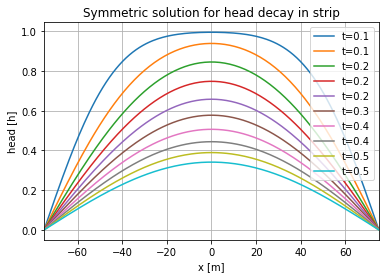

In [122]:
plt.title('Symmetric solution for head decay in strip')
plt.xlabel('x [m]')
plt.ylabel('head [h]')
plt.grid()
plt.xlim((-b, b))
for t in times:
    h = a * S * step(x, t, S, kD, b)
    plt.plot(x, h, label='t={:.1f}'.format(t))
plt.legend()
plt.show()

Let's take a time and show how the individual terms add up to yield the final solution.

## Get Meteo

The meteo is in a simple text file. It is most easily read in by pandas to yield a pandas DataFrame.

The DaraFrame is dressed up by column names and also its index is given a name.

Finally we add a column `days` to the DatFrame, holding the number of days since the first date in the file. We'll use these days as our simulation time. We will nevertheless use the index of the DataFrame as the time axis in our plots to reveal the true dates.

In [74]:
meteo = pd.read_csv('PE-00-08.txt', index_col=0, header=None, parse_dates=True, dayfirst=True)
meteo.columns = ['P', 'E']  # give the columns a name
meteo.index.name = 'time'   # given the index a name

# add column 'days' that are days since first day of the data (for convenience only)
meteo['days'] = (meteo.index - meteo.index[0]) / np.timedelta64(1, 'D')

# show what we've got (note that P and E are in mm/d not in m/d)
# first 5 lines
meteo.iloc[:5]

,P,E,days
time,,,
2000-01-01,1.000,0.1,0.0
2000-01-02,0.005,0.1,1.0
2000-01-03,4.500,0.0,2.0
2000-01-04,10.900,0.0,3.0
2000-01-05,0.000,0.4,4.0


## Convolution

The steady state head is

$$ s_{steady} = \frac  p {2 kD}  (b^2 - x^2) $$

For comparison, we will also plot this steady head for $p$ equal to the average recharge.

In [150]:
# new data

L = 4000 # m (strip width)
b =L/2 # [m] half width of strip
x = 0. # point taken at cross section
kD = 600 # m2/d
S = 0.25 # [-]
a = 1.0 # m, sudden head change at x = -L/2
times = np.linspace(0, 0.5, 11)[1:] #        

In [151]:
# Get the dynamic response

# Get time tau directly from the column days, then the vector tau is of equal length as the total
# time series, which will yield maximum accuracy (no truncation errors).
tau = meteo['days'].values

# Then compute the response
response = step(x, tau, S, kD, b)

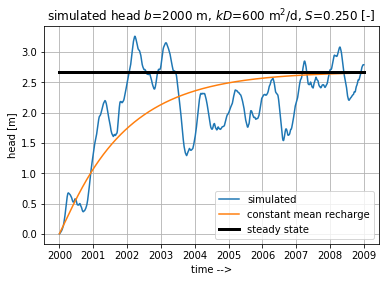

In [152]:
# Do the convolution

mmtom = 1/ 1000. # conversion from mm to m
rch = ((meteo['P'] - meteo['E']) * mmtom).values # get the recharge in m/d

# Design a vadose-zone filter (here just uniform, but any shape can be chosen)
n = 30 # length of vadose filter
vadose_filter = np.ones(n) / n

# Filter the recharge to get the recharge at the water table
rch = lfilter(vadose_filter, 1, rch)

# steady state for mean recharge
steady = np.mean(rch) / (2 * kD) * (b**2 - x**2)

# add the simulated result as a column to the data frame (this is not necessary, though)
meteo['sim'] = lfilter(response, 1, rch)

# set up the plot
plt.title('simulated head $b$={:.0f} m, $kD$={:.0f} m$^2$/d, $S$={:.3f} [-]'.format(b, kD, S))
plt.xlabel('time -->')
plt.ylabel('head [m]')
plt.grid()

# plot simulate result
plt.plot(meteo.index, meteo['sim'], label='simulated')

# plot the simulation for a constant recharge equal to the average value
plt.plot(meteo.index, lfilter(response, 1, np.mean(rch) * np.ones_like(rch)), label='constant mean recharge')

# plot the steady state result for the case of  average recharge
plt.plot(meteo.index[[0, -1]], [steady, steady], 'k', lw=3, label='steady state')

plt.legend()
plt.show()

## Discussion

This simulation by convolution with vadose-zone prefilter is extremely efficient in simulating the response of a general groundwater system to time-varying recharge (values positive and negative). Different groundwater systems can be simulated by adapting the parameter like the prefilter, telling the rate at which recharge reaches the water table, the size of the basin (half-width $b$), the transmissivity of the aquifer and its storage coefficient, which must, of course be the specific yield because we deal with a free water table.

This simple simulator is effective in showing how the characteristics of a groundwater system carries on in its response to recharge over longer periods.

The steady-state results for the average recharge functions as a check.

The transient result of constant recharge serves to clearly see characteristic time of the system or, for that sake, its half time, i.e. the time it takes to reach half the value of the steady stead head.